## 03_06: Serve webpages with flask

* Flask: https://flask.palletsprojects.com

In [1]:
import io
import base64

import requests
import bs4

import PIL.Image
import PIL.ImageOps
import PIL.ImageEnhance

In [2]:
def getstereo(date):
    # get SDO index for date, find all 512x512 171-angstrom images 
    indexreq = requests.get(f'https://sdo.gsfc.nasa.gov/assets/img/browse/{date}')
    soup = bs4.BeautifulSoup(indexreq.content, 'lxml')
    filenames = [link.string for link in soup.pre.find_all('a')
                             if link.string.endswith('512_0171.jpg')]
    
    # get two images across the day
    images = []
    # note integer division in case there's an odd number
    for filename in [filenames[0], filenames[len(filenames)//2]]:
        imagereq = requests.get(f'https://sdo.gsfc.nasa.gov/assets/img/browse/{date}/{filename}')
        images.append(PIL.Image.open(io.BytesIO(imagereq.content)))
    
    # grayscale + colorize the two images
    red  = PIL.ImageOps.colorize(images[0].convert('L'), (0,0,0), (255,0,0))
    cyan = PIL.ImageOps.colorize(images[1].convert('L'), (0,0,0), (0,255,255))

    # blend and adjust brightness
    blend = PIL.Image.blend(red, cyan, 0.5)
    final = PIL.ImageEnhance.Brightness(blend).enhance(2.5)
    
    return final

In [3]:
img = getstereo('2016/05/09')

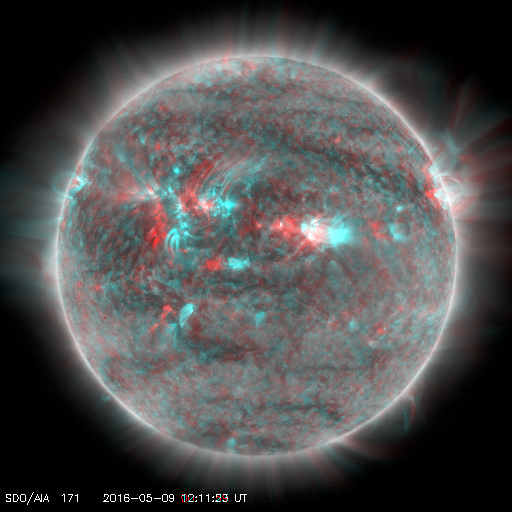

In [4]:
img

* `getstereo.py` containns this code.
* Use `getstereo.getcached()` if `getstereo.getstereo()` fails because of web problems

In [5]:
%%file server.py

import flask

app = flask.Flask(__name__)

@app.route('/')
def hello_world():
    return flask.Response('<html><body><p>Hello, world!</p></body></html>')

app.run(host='0.0.0.0')

Overwriting server.py


In [6]:
%%file server.py

import flask

import getstereo

app = flask.Flask(__name__)

@app.route('/<year>/<month>/<day>')
def getimage(year, month, day):
    stereo = getstereo.getstereo(f'{year}/{month}/{day}')
    return flask.Response("Got it!")

app.run(host='0.0.0.0')

Overwriting server.py


In [7]:
buffer = io.BytesIO()
img.save(buffer, format='PNG')

In [8]:
buffer.getvalue()[:100]

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00{\x1aC\xad\x00\x01\x00\x00IDATx\x9c\xec\xfdm\x8b,I\xae-\x0c\xea\x91F\xb8\xe3d\x92t\xd3\xdc\xa6\x99\x87\x81\xf9\xff\xffh`\xbe\x1c\xe6r\xb8\x87\xa2\x8a$\x02\xc3\x0c!1\x1f\x96In\xee\x91\xbb\xba\xbaO\xf7\xe9\xaa\xaem'

In [9]:
base64.b64encode(buffer.getvalue())[:100]

b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR4nOz9bYssSa4tDOqRRrjjZJJ009ymmYeB+f//aGC+HOZy'

In [10]:
b64image = base64.b64encode(buffer.getvalue()).decode('ascii')

''
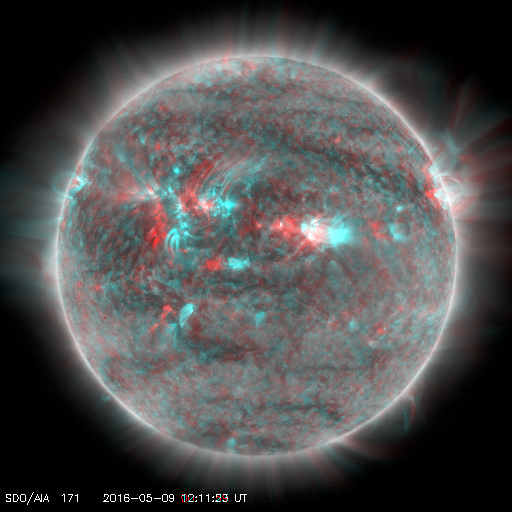

In [11]:
f'<img src="data:image/png;base64,{b64image}"/>'


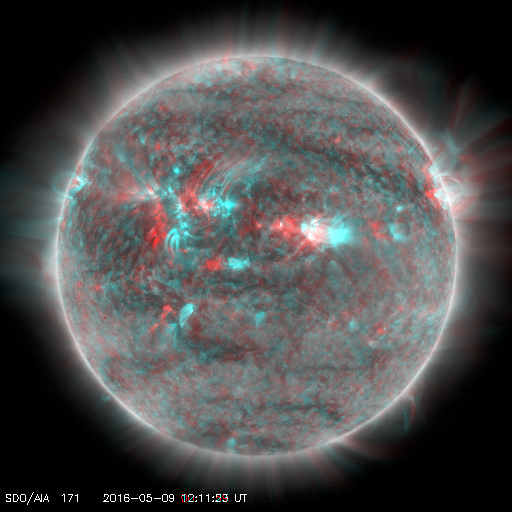

In [12]:
import IPython
IPython.display.HTML(data=f'<img src="data:image/png;base64,{b64image}"/>')

In [13]:
%%file server.py

import flask

import getstereo

app = flask.Flask(__name__)

@app.route('/<year>/<month>/<day>')
def getimage(year, month, day):
    stereo = getstereo.getstereo(f'{year}/{month}/{day}')
    inline = getstereo.makebase64(stereo)
    
    return flask.Response(f'<html><body>{inline}</body></html>')

app.run(host='0.0.0.0')

Overwriting server.py
